## 11 Effect of non-random mixing on rubella transmission and control
#### Overview
In part I, you will calculate the WAIFW matrix for different assumptions about mixing patterns, using values of the age-specific force of infection for rubella for the UK. In part II, you will explore the implications of different mixing patterns on the impact of MMR vaccination on the transmission dynamics of rubella.

### PART I: Calculating WAIFW matrices
To describe the transmission dynamics of rubella in the UK, accounting for this age-dependency, we will use an age-structured SEIR modelwith the following structure:    
                          
The population is stratified into three age classes, namely the young (0-14 years), middle-aged (15-29 years) and the old (≥30 years). Young and middle-aged individuals spend an average of 15 years in each compartment; old individuals spend an average of 30 years in the old compartment. Deaths only affect individuals in the old compartment. The total population size remains constant over time with 60,000 individuals, and 15,000, 15,000 and 30,000 young, middle-aged and old individuals respectively. Newly infected individuals typically became infectious after an average period of 10 days and stay infectious for an average of 11 days thereafter.

1. Fill in the table below.

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as spi
import pandas as pd

In [20]:
N = 60000    
N_y = 15000    # population size of young group 
N_m = 15000    # population size of middle-aged group
N_o = 30000    # population size of old group
b = 1/(60*365)   # natural birth rate
d = 1/(30*365)   # natural death rate
a_y = 1/(15*365) # rate at which young individuals age
a_m = 1/(15*365) # rate at which middle-aged individuals age
f = 1/10       # rate at which individuals become infectious
r = 1/11       # rate at which infectious individuals recover

 2. The number of infectious individuals can be calculated using the expression: force of infection*number of individuals who are susceptible*average duration of infectiousness Complete the following table to calculate the number of infectious individuals in each age category for the population in the mode.

In [21]:
lambda_y = 0.000364
lambda_m = 0.000114
lambda_o = 0.000114
S_y0 = 5012
S_m0 = 3083
S_o0 = 2739

I_y0 = lambda_y * S_y0 / r
I_m0 = lambda_m * S_m0 / r
I_o0 = lambda_o * S_o0 / r

print('Number of Infectioous\n▶ Young : %.1f\n▶ Middle-aged : %.1f\n▶ Old : %.1f\n'%(I_y0,I_m0,I_o0))

Number of Infectioous
▶ Young : 20.1
▶ Middle-aged : 3.9
▶ Old : 3.4



4. Calculate appropriate contact parameters βij for the following WAIFW matrix A and B:

In [22]:
WAIFW_A = np.zeros([3,3])

Abeta1 = lambda_y / I_y0
Abeta2 = lambda_m / I_m0
Abeta3 = lambda_o / I_o0

WAIFW_A[0,0] = Abeta1
WAIFW_A[1,1] = Abeta2
WAIFW_A[2,2] = Abeta3

WAIFW_B = np.zeros([3,3])

Bbeta3 = lambda_o / (I_y0+I_m0+I_o0)
Bbeta2 = (lambda_m - I_o0 * Bbeta3) / (I_y0+I_m0)
Bbeta1 = (lambda_y - I_m0 * Bbeta2 - I_o0 * Bbeta3) / I_y0

WAIFW_B[:,:] = Bbeta3
WAIFW_B[0:2,0:2] = Bbeta2
WAIFW_B[0,0] = Bbeta1

beta = 1.0530e-05
WAIFW_H = beta*np.ones([3,3])

print('WAIFW A : beta_1 = %.7f, beta_2 = %.7f , beta_3 = %.7f\nWAIFW B : beta_1 = %.7f , beta_2 = %.7f, beta_3 = %.7f\n'%(Abeta1,Abeta2,Abeta3,Bbeta1,Bbeta2,Bbeta3))

WAIFW A : beta_1 = 0.0000181, beta_2 = 0.0000295 , beta_3 = 0.0000332
WAIFW B : beta_1 = 0.0000166 , beta_2 = 0.0000042, beta_3 = 0.0000042



### PART II: The implications of heterogeneous mixing

In [23]:
E_y0 = 0; R_y0 = N_y-S_y0-I_y0
E_m0 = 0; R_m0 = N_m-S_m0-I_m0
E_o0 = 0; R_o0 = N_o-S_o0-I_o0  # S랑 I는 2번 정답에서 나온거 이용

initial_value = np.array([S_y0,E_y0,I_y0,R_y0,
                          S_m0,E_m0,I_m0,R_m0,
                          S_o0,E_o0,I_o0,R_o0])
t_stamp = np.arange(1,200*365+1,1)
def vac(c,t):
    if t>100*365+1:
        v = c
    else:
        v = 0
    return v

def ODEftn(WAIFW,c,y,t):
    Yp = np.zeros((12))
    Infec = np.array([[y[2]],[y[6]],[y[10]]])
    Lam = WAIFW@Infec
    Yp[0] = -a_y*y[0]+(1-vac(c,t))*N*b-Lam[0]*y[0]
    Yp[1] = -a_y*y[1]+Lam[0]*y[0]-f*y[1]
    Yp[2] = -a_y*y[2]+f*y[1]-r*y[2]
    Yp[3] = -a_y*y[3]+vac(c,t)*N*b+r*y[2]
    Yp[4] = a_y*y[0]-a_m*y[4]-Lam[1]*y[4]
    Yp[5] = a_y*y[1]-a_m*y[5]+Lam[1]*y[4]-f*y[5]
    Yp[6] = a_y*y[2]-a_m*y[6]+f*y[5]-r*y[6]
    Yp[7] = a_y*y[3]-a_m*y[7]+r*y[6]
    Yp[8] = a_m*y[4]-d*y[8]-Lam[2]*y[8]
    Yp[9] = a_m*y[5]-d*y[9]+Lam[2]*y[8]-f*y[9]
    Yp[10] = a_m*y[6]-d*y[10]+f*y[9]-r*y[10]
    Yp[11] = a_m*y[7]-d*y[11]+r*y[10]
    return Yp


def WAIFW_H_wihtout_vac(y,t):
    return ODEftn(WAIFW_H,0,y,t)

def WAIFW_A_wihtout_vac(y,t):
    return ODEftn(WAIFW_A,0,y,t)

def WAIFW_B_wihtout_vac(y,t):
    return ODEftn(WAIFW_B,0,y,t)

def WAIFW_A_wiht_vac(y,t):
    return ODEftn(WAIFW_A,0.86,y,t)

def WAIFW_B_wiht_vac(y,t):
    return ODEftn(WAIFW_B,0.86,y,t)

In [24]:
def vac(c,t):
    if t>100*365+1:
        v = c
    else:
        v = 0
    return v

def ODEftn(WAIFW,c,y,t):
    Yp = np.zeros((12))
    Infec = np.array([[y[2]],[y[6]],[y[10]]])
    Lam = WAIFW@Infec
    Yp[0] = -a_y*y[0]+(1-vac(c,t))*N*b-Lam[0]*y[0]
    Yp[1] = -a_y*y[1]+Lam[0]*y[0]-f*y[1]
    Yp[2] = -a_y*y[2]+f*y[1]-r*y[2]
    Yp[3] = -a_y*y[3]+vac(c,t)*N*b+r*y[2]
    Yp[4] = a_y*y[0]-a_m*y[4]-Lam[1]*y[4]
    Yp[5] = a_y*y[1]-a_m*y[5]+Lam[1]*y[4]-f*y[5]
    Yp[6] = a_y*y[2]-a_m*y[6]+f*y[5]-r*y[6]
    Yp[7] = a_y*y[3]-a_m*y[7]+r*y[6]
    Yp[8] = a_m*y[4]-d*y[8]-Lam[2]*y[8]
    Yp[9] = a_m*y[5]-d*y[9]+Lam[2]*y[8]-f*y[9]
    Yp[10] = a_m*y[6]-d*y[10]+f*y[9]-r*y[10]
    Yp[11] = a_m*y[7]-d*y[11]+r*y[10]
    return Yp


def WAIFW_H_wihtout_vac(y,t):
    return ODEftn(WAIFW_H,0,y,t)

def WAIFW_A_wihtout_vac(y,t):
    return ODEftn(WAIFW_A,0,y,t)

def WAIFW_B_wihtout_vac(y,t):
    return ODEftn(WAIFW_B,0,y,t)

def WAIFW_A_wiht_vac(y,t):
    return ODEftn(WAIFW_A,0.86,y,t)

def WAIFW_B_wiht_vac(y,t):
    return ODEftn(WAIFW_B,0.86,y,t)
    
# Differential Method
Original = spi.odeint(WAIFW_H_wihtout_vac,initial_value,t_stamp)
MatrixA = spi.odeint(WAIFW_A_wihtout_vac,initial_value,t_stamp)
MatrixB = spi.odeint(WAIFW_B_wihtout_vac,initial_value,t_stamp)
MatrixA_vac = spi.odeint(WAIFW_A_wiht_vac,initial_value,t_stamp)
MatrixB_vac = spi.odeint(WAIFW_B_wiht_vac,initial_value,t_stamp)

#### 1.Compare the long-term age-specific values for the proportion of individuals who are susceptible and the daily number of new infections per 100,000 computed with and without incorporating WAIFW. Is this what you would expect? Why?

In [25]:
# proportion of S 
prop_Sy_H = 100*Original[-1,0]/N_y 
prop_Sm_H = 100*Original[-1,4]/N_m 
prop_So_H = 100*Original[-1,8]/N_o

prop_Sy_A = 100*MatrixA[-1,0]/N_y 
prop_Sm_A = 100*MatrixA[-1,4]/N_m 
prop_So_A = 100*MatrixA[-1,8]/N_o

prop_Sy_B = 100*MatrixB[-1,0]/N_y 
prop_Sm_B = 100*MatrixB[-1,4]/N_m 
prop_So_B = 100*MatrixB[-1,8]/N_o

# Daily number of new infectious/100,000
NewI_H_y = (100000/N_y)*f*(Original[-2,1]+Original[-1,1])/2
NewI_H_m = (100000/N_m)*f*(Original[-2,5]+Original[-1,5])/2
NewI_H_o = (100000/N_o)*f*(Original[-2,9]+Original[-1,9])/2

NewI_A_y = (100000/N_y)*f*(MatrixA[-2,1]+MatrixA[-1,1])/2
NewI_A_m = (100000/N_m)*f*(MatrixA[-2,5]+MatrixA[-1,5])/2
NewI_A_o = (100000/N_o)*f*(MatrixA[-2,9]+MatrixA[-1,9])/2

NewI_B_y = (100000/N_y)*f*(MatrixB[-2,1]+MatrixB[-1,1])/2
NewI_B_m = (100000/N_m)*f*(MatrixB[-2,5]+MatrixB[-1,5])/2
NewI_B_o = (100000/N_o)*f*(MatrixB[-2,9]+MatrixB[-1,9])/2

print("""\n <<Average susceptible Proportion>>\n
    1. Homogeneous\n Young = %.2f \t Middle = %.2f \t Old = %.2f \n
    2. WAIFW A\n Young = %.2f \t Middle = %.2f \t Old = %.2f \n
    3. WAIFW B\n Young = %.2f \t Middle = %.2f \t Old = %.2f \n
    \n <<Dialy New incidence>> \n
    1. Homogeneous\n Young = %.2f \t Middle = %.2f \t Old = %.2f \n
    2. WAIFW A\n Young = %.2f \t Middle = %.2f \t Old = %.2f \n
    3. WAIFW B\n Young = %.2f \t Middle = %.2f \t Old = %.2f \n"""
    %(prop_Sy_H,prop_Sm_H,prop_So_H,prop_Sy_A,prop_Sm_A,prop_So_A,
     prop_Sy_B,prop_Sm_B,prop_So_B,NewI_H_y,NewI_H_m,NewI_H_o,
     NewI_A_y,NewI_A_m,NewI_A_o,NewI_B_y,NewI_B_m,NewI_B_o))


 <<Average susceptible Proportion>>

    1. Homogeneous
 Young = 37.29 	 Middle = 13.90 	 Old = 3.19 

    2. WAIFW A
 Young = 33.54 	 Middle = 20.24 	 Old = 9.11 

    3. WAIFW B
 Young = 33.49 	 Middle = 20.62 	 Old = 9.17 

    
 <<Dialy New incidence>> 

    1. Homogeneous
 Young = 11.43 	 Middle = 4.28 	 Old = 0.98 

    2. WAIFW A
 Young = 12.12 	 Middle = 2.45 	 Old = 1.02 

    3. WAIFW B
 Young = 12.13 	 Middle = 2.37 	 Old = 1.05 



### Vaccination of newborns is introduced 100 years after the start of the simulations at a level of vaccination coverage (86%) calculated for the UK. 

#### 2. What happens to the age-specific proportion of individuals who are susceptible and the daily number of new infections per 100,000 if you introduce 86% effective vaccination coverage into a population mixing according to WAIFW A? Why?

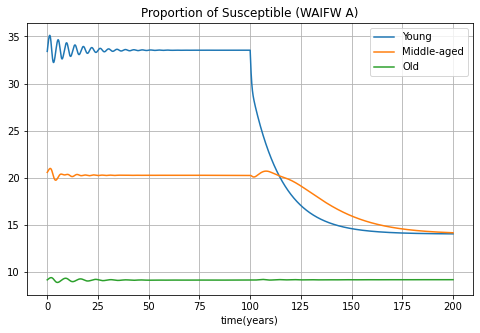

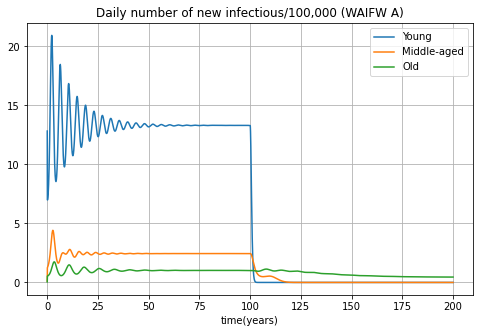

In [26]:
prop_Sy_A_vac = 100*MatrixA_vac[:,0]/N_y 
prop_Sm_A_vac = 100*MatrixA_vac[:,4]/N_m 
prop_So_A_vac = 100*MatrixA_vac[:,8]/N_o

NewI_A_y_vac = (100000/N_y)*f*(MatrixA_vac[0:-1,2]+MatrixA_vac[1:,2])/2
NewI_A_m_vac = (100000/N_m)*f*(MatrixA_vac[0:-1,5]+MatrixA_vac[1:,5])/2
NewI_A_o_vac = (100000/N_o)*f*(MatrixA_vac[0:-1,9]+MatrixA_vac[1:,9])/2

plt.figure(figsize = (8,5))
plt.plot(t_stamp/365,prop_Sy_A_vac,label = 'Young')
plt.plot(t_stamp/365,prop_Sm_A_vac,label = 'Middle-aged')
plt.plot(t_stamp/365,prop_So_A_vac,label = 'Old')
plt.legend()
plt.xlabel('time(years)')
plt.title('Proportion of Susceptible (WAIFW A)')
plt.grid()

plt.figure(figsize = (8,5))
tt_stamp = t_stamp[:-1]
plt.plot(tt_stamp/365,NewI_A_y_vac,label = 'Young')
plt.plot(tt_stamp/365,NewI_A_m_vac,label = 'Middle-aged')
plt.plot(tt_stamp/365,NewI_A_o_vac,label = 'Old')
plt.legend()
plt.xlabel('time(years)')
plt.title('Daily number of new infectious/100,000 (WAIFW A)')
plt.grid()

3. What happens to the age-specific proportion of individuals who are susceptible and the daily number of new infections per 100,000 if you introduce 86% effective vaccination coverage into a population mixing according to WAIFW B? Why?

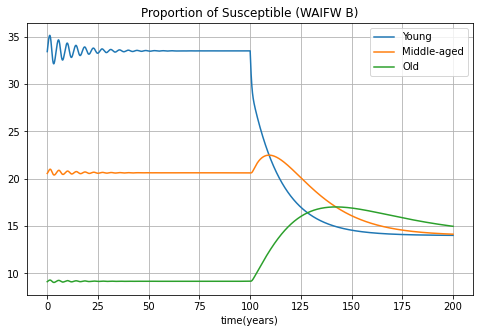

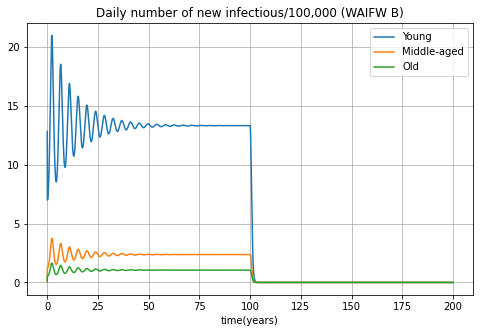

In [27]:
prop_Sy_B_vac = 100*MatrixB_vac[:,0]/N_y 
prop_Sm_B_vac = 100*MatrixB_vac[:,4]/N_m 
prop_So_B_vac = 100*MatrixB_vac[:,8]/N_o

NewI_B_y_vac = (100000/N_y)*f*(MatrixB_vac[0:-1,2]+MatrixB_vac[1:,2])/2
NewI_B_m_vac = (100000/N_m)*f*(MatrixB_vac[0:-1,5]+MatrixB_vac[1:,5])/2
NewI_B_o_vac = (100000/N_o)*f*(MatrixB_vac[0:-1,9]+MatrixB_vac[1:,9])/2

plt.figure(figsize = (8,5))
plt.plot(t_stamp/365,prop_Sy_B_vac,label = 'Young')
plt.plot(t_stamp/365,prop_Sm_B_vac,label = 'Middle-aged')
plt.plot(t_stamp/365,prop_So_B_vac,label = 'Old')
plt.legend()
plt.xlabel('time(years)')
plt.title('Proportion of Susceptible (WAIFW B)')
plt.grid()

plt.figure(figsize = (8,5))
tt_stamp = t_stamp[:-1]
plt.plot(tt_stamp/365,NewI_B_y_vac,label = 'Young')
plt.plot(tt_stamp/365,NewI_B_m_vac,label = 'Middle-aged')
plt.plot(tt_stamp/365,NewI_B_o_vac,label = 'Old')
plt.legend()
plt.xlabel('time(years)')
plt.title('Daily number of new infectious/100,000 (WAIFW B)')
plt.grid()

4. As you shall see in the next practical, the R0 for populations with mixing patterns described by WAIFW A and B are about 10.9 and 3.6, respectively. Use these values of the basic reproduction number to calculate the critical levels of vaccination coverage for these populations. Is this consistent with your answer to the previous question? What do you conclude from this exercise?

In [28]:
R0_A = 10.9
R0_B = 3.6
print('critical levels of vaccination coverage\nWAIFW A : %.1f%% \nWAIFW B : %.1f%%'%((1-1/R0_A)*100,(1-1/R0_B)*100))


critical levels of vaccination coverage
WAIFW A : 90.8% 
WAIFW B : 72.2%
